In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('ecommerce_data.csv')

In [3]:
df.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day,user_action
0,1,0,0.657510,0,3,0
1,1,1,0.568571,0,2,1
2,1,0,0.042246,1,1,0
3,1,1,1.659793,1,1,2
4,0,1,2.014745,1,1,2


In [22]:
print('Num of rows: ' + str(df.shape[0])) #row count
print('Num of columns: ' + str(df.shape[1])) #column count

Num of rows: 500
Num of columns: 6


In [23]:
class_dict = {
    0: 'bounce',
    1: 'add_to_cart',
    2: 'begin_checkout',
    3: 'finish_checkout'
}

df.loc[:,'user_action2'] = df['user_action'].map(class_dict)

In [24]:
df.user_action2.value_counts()

bounce             253
add_to_cart        145
begin_checkout      77
finish_checkout     25
Name: user_action2, dtype: int64

### Preprocess data

#### One Hot Encode

In [3]:
from sklearn.preprocessing import OneHotEncoder

df_cat = pd.get_dummies(df, columns = ['time_of_day'])

In [4]:
df_cat.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,user_action,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3
0,1,0,0.657510,0,0,0,0,0,1
1,1,1,0.568571,0,1,0,0,1,0
2,1,0,0.042246,1,0,0,1,0,0
3,1,1,1.659793,1,2,0,1,0,0
4,0,1,2.014745,1,2,0,1,0,0


#### Split data set

In [5]:
y = df_cat['user_action']

to_drop = ['user_action']
X = df_cat.drop(to_drop, axis = 1)

X.head()

,is_mobile,n_products_viewed,visit_duration,is_returning_visitor,time_of_day_0,time_of_day_1,time_of_day_2,time_of_day_3
0,1,0,0.657510,0,0,0,0,1
1,1,1,0.568571,0,0,0,1,0
2,1,0,0.042246,1,0,1,0,0
3,1,1,1.659793,1,0,1,0,0
4,0,1,2.014745,1,0,1,0,0


In [6]:
from sklearn import model_selection

# Reserve 20% for testing

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

print('training data has ' + str(X_train.shape[0]) + ' observation with ' + str(X_train.shape[1]) + ' features')
print('test data has ' + str(X_test.shape[0]) + ' observation with ' + str(X_test.shape[1]) + ' features')

training data has 400 observation with 8 features
test data has 100 observation with 8 features


#### Scale the Data

In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scaler = StandardScaler()
num_feat = ['n_products_viewed', 'visit_duration']
X_train_num = X_train[num_feat]
X_train_cat = X_train.drop(num_feat, axis = 1)
X_test_num = X_test[num_feat]
X_test_cat = X_test.drop(num_feat, axis = 1)
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)
X_train = np.concatenate((X_train_num, X_train_cat), axis = 1)
X_test = np.concatenate((X_test_num, X_test_cat), axis = 1)

In [8]:
y_test = y_test.values
y_train = y_train.values

### Multi-class Classification

In [13]:
from sklearn.linear_model import LogisticRegression

#classifier_logistic = LogisticRegression()
#classifier_logistic.fit(X_train, y_train)

In [14]:
from sklearn.model_selection import GridSearchCV
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(1, 5, 10)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=5)
Grid_LR.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'penalty': ('l1', 'l2'), 'C': (1, 5, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
def print_grid_search_metrics(gs):
    print ("Best score: " + str(gs.best_score_))
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print(param_name + ':' + str(best_parameters[param_name]))

print_grid_search_metrics(Grid_LR)

Best score: 0.8625
Best parameters set:
C:10
penalty:l1


In [17]:
classifier_logistic = LogisticRegression(penalty='l1', C = 10)
classifier_logistic.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
y_train_predicted = classifier_logistic.predict(X_train)
print('train set accuracy score is ', np.mean(y_train == y_train_predicted))

train set accuracy score is  0.8725


In [21]:
y_test_predicted = classifier_logistic.predict(X_test)
print('test set acciracy score is ', np.mean(y_test == y_test_predicted))

test set acciracy score is  0.83


The score is ok but not great. Next, i am going to add one hidden layer

### Two Layer NN

When using NN, i am not going to use any blackbox package. One is to reinforce my understanding of the forward and back propagation process and the other is more clear about what is going on in the algorithm

#### Data Preproccessing

i am going to use softmax to get multi-class prediction. Therefore, need to transform original denpent variable into indication matrix

In [36]:
# transfer y into indicator matrix

def y2indicator(y, K):
    N = len(y)
    ind = np.zeros((N, K))
    for i in range(N):
        ind[i, y[i]] = 1
    return ind

In [53]:
K = len(set(y_train))
Ytrain_ind = y2indicator(y_train, K)
Ytest_ind = y2indicator(y_test, K)

#### Forward propagation

In [92]:
# define forward function

def forward(X, W1, b1, W2, b2):
    Z = 1 / (1+np.exp(-X.dot(W1) - b1))
    A = Z.dot(W2) + b2
    expA = np.exp(A)
    Y = expA/expA.sum(axis = 1, keepdims = True)
    return Y, Z

In [77]:
# since the output is probability, this function will give the class with highest probability
def predict(P_Y_given_X):
    return np.argmax(P_Y_given_X, axis = 1)


#### Backward Propagation

In [90]:
# backpropogation function
def derivative_w2(Z, T, Y):
    return Z.T.dot(T - Y)

def derivative_b2(T, Y):
    return np.sum(T-Y, axis = 0)

def derivative_w1(X, Z, T, Y, W2):
    return X.T.dot((T-Y).dot(W2.T) * Z * (1-Z))

def derivative_b1(T, Y, W2, Z):
    return np.sum((T-Y).dot(W2.T) * Z * (1-Z), axis = 0)

#### Accuracy Matrix

In [78]:
# Use the Accuracy as the accuracy matrix
def classification_rate(Y, P):
    return np.mean(Y== P)

#### Cost Function

In [79]:
# cross entropy cost function for multi class
def cross_entropy(T, pY):
    return -np.mean(T*np.log(pY))

In [109]:
M = 10 # 10 hidden layers
# randomly initialize weights
W1 = np.random.randn(D, M)
b1 = np.random.randn(M)
W2 = np.random.randn(M, K)
b2 = np.random.randn(K)

In [110]:
train_costs = []
test_costs = []
learning_rate = 0.001
for i in range(10000):
    pYtrain, hidden = forward(X_train, W1, b1, W2, b2)
    pYtest, _ = forward(X_test, W1, b1, W2, b2)
    
    ctrain = cross_entropy(Ytrain_ind, pYtrain)
    ctest = cross_entropy(Ytest_ind, pYtest)
    
    train_costs.append(ctrain)
    test_costs.append(ctest)
    
    #W -= learning_rate * X_train.T.dot(pYtrain - Ytrain_ind)
    #b -= learning_rate * (pYtrain - Ytrain_ind).sum(axis = 0)
    W2 += learning_rate * derivative_w2(hidden, Ytrain_ind, pYtrain)
    b2 += learning_rate * derivative_b2(Ytrain_ind, pYtrain)
    W1 += learning_rate * derivative_w1(X_train, hidden, Ytrain_ind, pYtrain, W2)
    b1 += learning_rate * derivative_b1(Ytrain_ind, pYtrain, W2, hidden)
    
    if i % 1000 == 0:
        print('current loop:' + str(i) + ' cost of train: ' + str(ctrain) + ' cost of test: ' + str(ctest))
        
print('Final train classification_rate: ', classification_rate(y_train, predict(pYtrain)))
print('Final test classification_rate: ', classification_rate(y_test, predict(pYtest)))

current loop:0 cost of train: 0.695216377047 cost of test: 0.718207894631
current loop:1000 cost of train: 0.0415635174455 cost of test: 0.0566706623109
current loop:2000 cost of train: 0.0239324553139 cost of test: 0.0421191632881
current loop:3000 cost of train: 0.0177044716927 cost of test: 0.0385560415374
current loop:4000 cost of train: 0.0143115235628 cost of test: 0.038123349563
current loop:5000 cost of train: 0.0119969383594 cost of test: 0.0392398724156
current loop:6000 cost of train: 0.0103067318502 cost of test: 0.0412994420994
current loop:7000 cost of train: 0.00900963684557 cost of test: 0.0438929396627
current loop:8000 cost of train: 0.00797116083503 cost of test: 0.0467226310135
current loop:9000 cost of train: 0.00711560653269 cost of test: 0.0495676896744
Final train classification_rate:  0.9975
Final test classification_rate:  0.94


###### Only add one more layer has improved the score a lot!

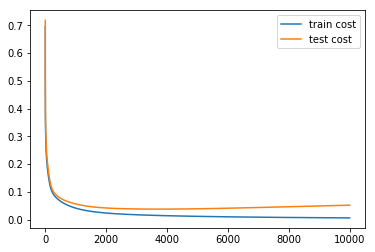

In [111]:
import matplotlib.pyplot as plt
plt.plot(train_costs, label = 'train cost')
plt.plot(test_costs, label = 'test cost')
plt.legend()
plt.show()